<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import date

start_date = '20040101'
end_date = date.today().strftime("%Y%m%d")

In [2]:
import requests

otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
otp = requests.post(otp_url, data={'locale' : 'ko_KR', 
                                   'searchType' : 'P',
                                   'idxIndMidclssCd' : '01',
                                   'indTpCd' : '1',
                                   'indTpCd2' : '001',
                                   'tboxindTpCd_finder_equidx0_0' : '코스피',
                                   'codeNmindTpCd_finder_equidx0_0': '코스피',
                                   'strtDd' : start_date,
                                   'endDd' : end_date,
                                   'name' : 'fileDown',
                                   'url' : 'dbms/MDC/STAT/standard/MDCSTAT00702'}).content

In [3]:
download_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
download = requests.post(download_url, data={'code': otp}).content

In [4]:
import pandas as pd
import io

df = pd.read_csv(io.BytesIO(download), encoding='cp949')
df

,일자,종가,대비,등락률,PER,선행 PER,PBR,배당수익률
0,2022/02/04,2750.26,42.44,1.57,12.53,0,1.12,1.86
1,2022/02/03,2707.82,44.48,1.67,12.34,0,1.10,1.88
2,2022/01/28,2663.34,48.85,1.87,12.14,0,1.08,1.92
3,2022/01/27,2614.49,-94.75,-3.50,11.16,0,1.00,2.08
4,2022/01/26,2709.24,-11.15,-0.41,11.57,0,1.04,2.00
...,...,...,...,...,...,...,...,...
4471,2004/01/08,824.15,-2.92,-0.35,10.24,0,1.04,2.05
4472,2004/01/07,827.07,3.64,0.44,10.28,0,1.05,2.04
4473,2004/01/06,823.43,-0.67,-0.08,10.23,0,1.04,2.06
4474,2004/01/05,824.10,2.84,0.35,10.24,0,1.04,2.06


In [5]:
df.describe()

,종가,대비,등락률,PER,선행 PER,PBR,배당수익률
count,4476.000000,4476.000000,4476.000000,4476.000000,4476.0,4476.000000,4476.000000
mean,1870.887122,0.433322,0.035185,14.852270,0.0,1.195451,1.616736
std,525.337245,21.448884,1.249715,4.667137,0.0,0.211105,0.400129
min,719.590000,-133.560000,-10.570000,7.370000,0.0,0.000000,1.000000
25%,1576.082500,-9.422500,-0.510000,11.777500,0.0,1.070000,1.320000
50%,1948.980000,1.265000,0.070000,14.260000,0.0,1.160000,1.520000
75%,2091.015000,11.730000,0.670000,16.150000,0.0,1.300000,1.830000
max,3305.210000,127.510000,11.950000,33.350000,0.0,1.900000,3.150000


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def plot_hist(df, element):
  # colormap
  cm = plt.cm.get_cmap('RdYlBu_r')

  # Get the histogramp
  data = df[element]
  Y,X = np.histogram(data, 25)
  x_span = X.max()-X.min()
  C = [cm(((x-X.min())/x_span)) for x in X]

  plt.subplots(figsize=(7, 7))
  plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])

  # highlight
  height = Y[list(X).index(find_nearest(X, df.iloc[0][element]))]
  width = (X[1]-X[0])/len(X)
  plt.bar(df.iloc[0][element], height = height,  width=width, color = 'red')
  plt.show()

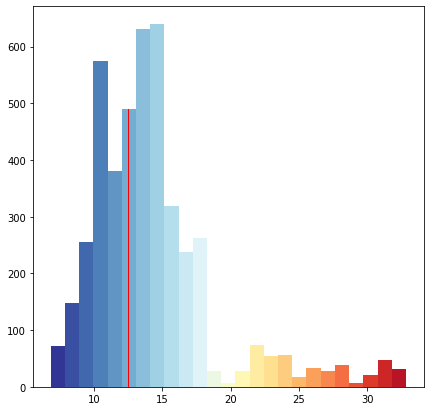

In [7]:
plot_hist(df, 'PER')

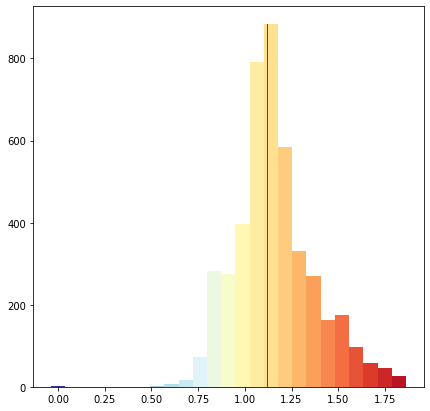

In [8]:
plot_hist(df, 'PBR')